In [1]:
import os
os.chdir('../')

from GenStudentMixtures.Mixture_Multivariate_Student_Generalized import MMST
from GenStudentMixtures.Multivariate_Student_Generalized import MST

from GenStudentMixtures.GenStudentMixtures import GenStudentMixtures
import numpy as np
from numpy.random import shuffle

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

## Sampling


### 3 clusters dim 2


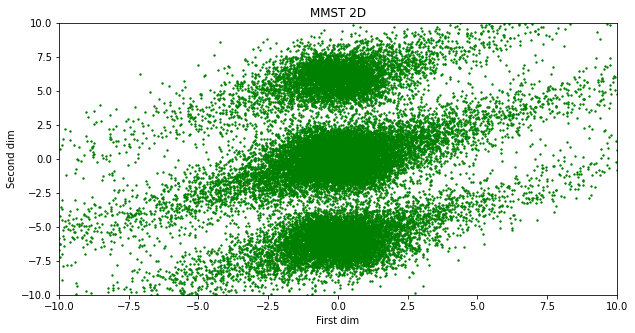

In [2]:
pi_23 = np.array([.3, .5, .2], dtype=np.float64)
mu_23 = np.array([[0, -6], [0, 0], [0, 6]], dtype=np.float64)
A_23 = np.ones((3, 2), dtype=np.float64)
angle = np.pi / 6
matRot_23 = [[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]]
D_23 = np.array([matRot_23, matRot_23, matRot_23], dtype=np.float64)
nu_23 = np.array([[1, 30], [1, 30], [1, 30]], dtype=np.float64)

gen_mix_23 = MMST(pi_23, mu_23, A_23, D_23, nu_23).sample(1000000)
key = lambda e: abs(e[0].max()) < 10 and abs(e[0].min()) < 10
gen_mix_23 = np.array(sorted(gen_mix_23, key=lambda e: abs(e.max()) < 10 and abs(e.min()) < 10)[::-1], dtype=np.float64)


plt.figure(figsize=(10, 5))

plt.scatter(gen_mix_23[:30000, 0], gen_mix_23[:30000, 1], s=1.9, c='green')

plt.xlim(-10, 10)
plt.xlabel('First dim')

plt.ylim(-10, 10)
plt.ylabel('Second dim')

plt.title('MMST 2D')
plt.show()

In [3]:
# real estimation 
model = KMeans(3, max_iter=3000, tol=1e-5)
gen_mix_init = gen_mix_23[:500]
model.fit(gen_mix_init)

# First prediction
pi_pred = np.array([(model.labels_ == k).sum() / len(model.labels_) for k in range(3)], dtype=np.float64)
mu_pred = np.array([gen_mix_init[model.labels_ == k].mean(0) for k in range(3)], dtype=np.float64)
D_pred = np.array([np.eye(2), np.eye(2), np.eye(2)], dtype=np.float64)
A_pred = np.ones(A_23.shape, dtype=np.float64)
nu_pred = 30 * np.ones(nu_23.shape, dtype=np.float64)

# Shuffle the data
shuffle(gen_mix_23)

# Learning rates
gam = (1-10e-10)*np.array([k for k in range(1, len(gen_mix_23) + 1)]) ** (-6/10)

# Training
model = GenStudentMixtures(pi_pred, mu_pred, A_pred, D_pred, nu_pred, max_iterations=2000)
model.fit(gen_mix_23, gam, 100)

 20%|███████▊                               | 2000/9999 [12:21<49:24,  2.70it/s]


In [4]:
print(pi_23, model.pi)

[0.3 0.5 0.2] [0.30309152 0.4954498  0.20145869]


In [5]:
permut_real2model = [0, 1, 2]

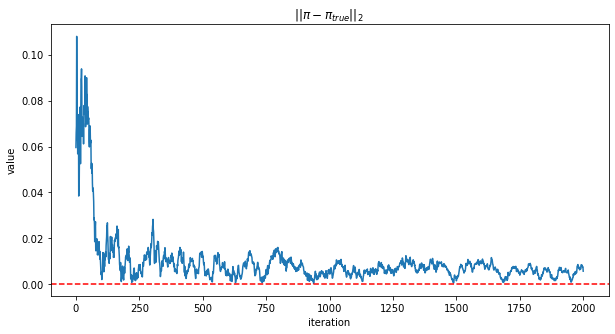

In [6]:
pi_curve = [np.linalg.norm(pi[permut_real2model] - pi_23, 2) for pi in model.pi_hist] 

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(pi_curve)), pi_curve)
plt.axhline(y = 0, color = 'r', linestyle = '--')

plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||\pi - \pi_{true}||_2$ ')
plt.show()

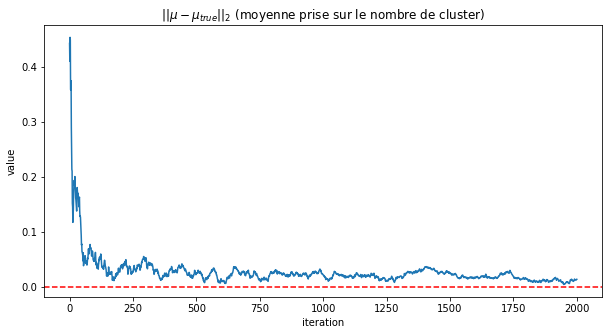

In [7]:
mu_curve = np.array([[np.linalg.norm(mu[permut_real2model][k]-mu_23[k], 2) for k in range(3)] for mu in model.mu_hist]).mean(axis=-1)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(mu_curve)), mu_curve)
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||\mu - \mu_{true}||_2$ (moyenne prise sur le nombre de cluster)')
plt.show()

In [8]:
tmp = np.swapaxes(model.D, 1, 2) @ D_23 / np.max(np.abs(np.swapaxes(model.D, 1, 2) @ D_23),
                                                         axis=-1)[..., np.newaxis]
permute = np.logical_or(tmp == 1, tmp == -1)

A_permut_hist = [(permute @ A[...,np.newaxis]).squeeze(-1) for A in model.A_hist]
nu_permut_hist = [(permute @ nu[...,np.newaxis]).squeeze(-1) for nu in model.nu_hist]
D_permut_hist = [permute @ np.abs(D) for D in model.D_hist]

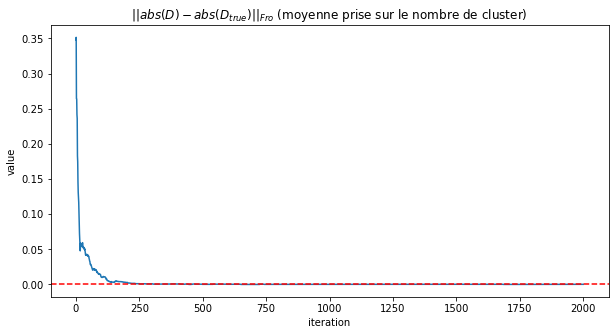

In [9]:
D_curve  = np.array([[np.linalg.norm(D[permut_real2model][k] - np.abs(D_23[k])) for k in range(3)] for D in D_permut_hist]).mean(axis=1)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(D_curve)), D_curve)
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||abs(D) - abs(D_{true})||_{Fro}$ (moyenne prise sur le nombre de cluster)')
plt.show()

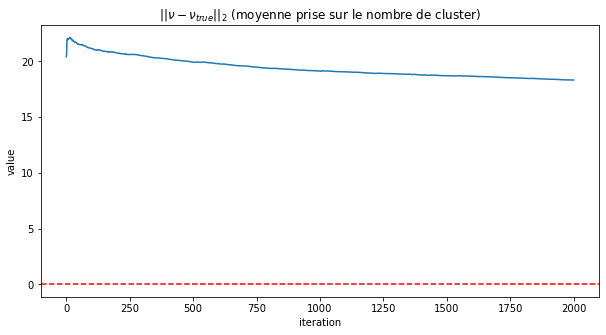

In [10]:
nu_curve = np.array([[np.linalg.norm(nu[permut_real2model][k]-nu_23[k], 2) for k in range(3)] for nu in nu_permut_hist]).mean(axis=-1)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(nu_curve)), nu_curve)
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||\nu - \nu_{true}||_2$ (moyenne prise sur le nombre de cluster)')
plt.show()

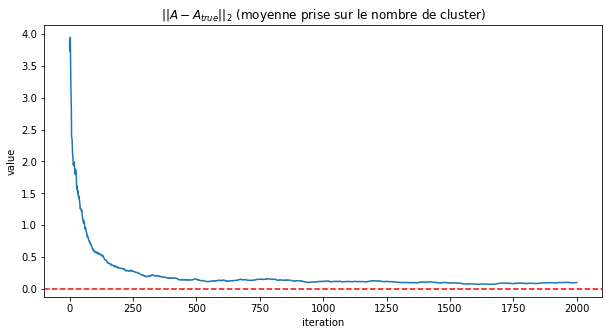

In [11]:
A_curve = np.array([[np.linalg.norm(A[permut_real2model][k]-A_23[k], 2) for k in range(3)] for A in A_permut_hist]).mean(axis=-1)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(A_curve)), A_curve)
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||A - A_{true}||_2$ (moyenne prise sur le nombre de cluster)')
plt.show()

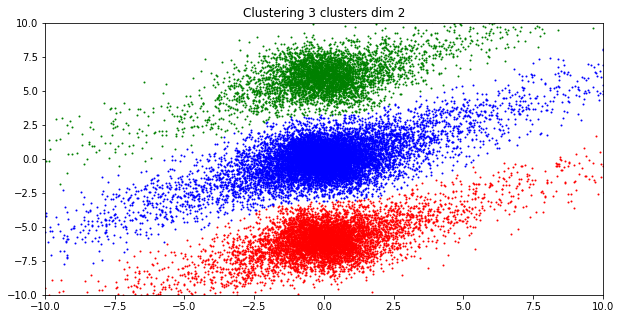

In [12]:
# clustering
cluster_lab = model.predict(gen_mix_23[:25000])

cdict = {0: 'red', 1: 'blue', 2: 'green'}

fig = plt.figure(figsize=(10, 5))

for g in np.unique(cluster_lab):
    ix = np.where(cluster_lab == g)
    plt.scatter(gen_mix_23[:,0][ix], gen_mix_23[:,1][ix], c = cdict[int(g)], label = int(g), s = 1)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.title('Clustering 3 clusters dim 2')

plt.show()

### 4 clusters 2 dims

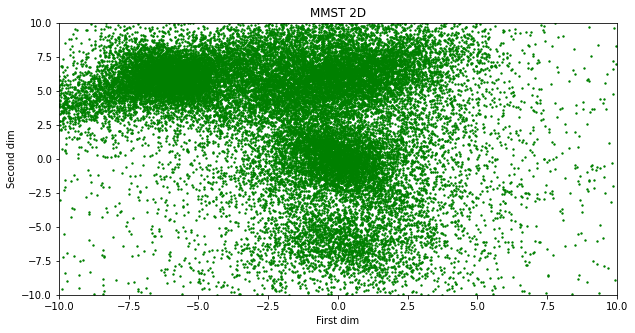

In [13]:
pi_24 = np.array([.1, .2, .3, .4], dtype=np.float64)
mu_24 = np.array([[0, -6], [0, 0], [0, 6], [-6, 6]], dtype=np.float64)
angle = np.pi / 6
matRot_24 = [[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]]
D_24 = np.array([matRot_24, matRot_24, matRot_24, matRot_24], dtype=np.float64)
A_24 = np.array([[2, 3], [1, 2.5], [5, 2], [1.5, 0.9]], dtype=np.float64)
nu_24 = np.array([[1, 2], [1.5, 2], [9, 2], [0.5, 3]], dtype=np.float64)

gen_mix_24 = MMST(pi_24, mu_24, A_24, D_24, nu_24).sample(1000000)
gen_mix_24 = np.array(sorted(gen_mix_24, key=lambda e: abs(e.max()) < 10 and abs(e.min()) < 10)[::-1], dtype=np.float64)

plt.figure(figsize=(10, 5))

plt.scatter(gen_mix_24[:30000, 0], gen_mix_24[:30000, 1], s=1.9, c='green')

plt.xlim(-10, 10)
plt.xlabel('First dim')

plt.ylim(-10, 10)
plt.ylabel('Second dim')

plt.title('MMST 2D')
plt.show()

In [14]:
# real estimation 
model = KMeans(4, max_iter=3000, tol=1e-5)
gen_mix_init = gen_mix_24[:2000]
model.fit(gen_mix_init)

pi_pred = np.array([(model.labels_ == k).sum() / len(model.labels_) for k in range(4)], dtype=np.float64)
mu_pred = np.array([gen_mix_init[model.labels_ == k].mean(0) for k in range(4)], dtype=np.float64)
D_pred = np.array([np.eye(2), np.eye(2), np.eye(2), np.eye(2)], dtype=np.float64)
A_pred = np.ones(A_24.shape, dtype=np.float64)
nu_pred = 30 * np.ones(nu_24.shape, dtype=np.float64)

# Shuffle the data
shuffle(gen_mix_24)

# Learning rates
gam = (1-10e-10)*np.array([k for k in range(1, len(gen_mix_24) + 1)]) ** (-6/10)

# Training
model = GenStudentMixtures(pi_pred, mu_pred, A_pred, D_pred, nu_pred, max_iterations=2000)
model.fit(gen_mix_24, gam, 100)

 20%|███████▊                               | 2000/9999 [14:55<59:41,  2.23it/s]


In [15]:
print(pi_24, model.pi)

[0.1 0.2 0.3 0.4] [0.31125056 0.39647291 0.17055557 0.12172097]


In [16]:
permut_real2model = [3, 2, 0, 1]

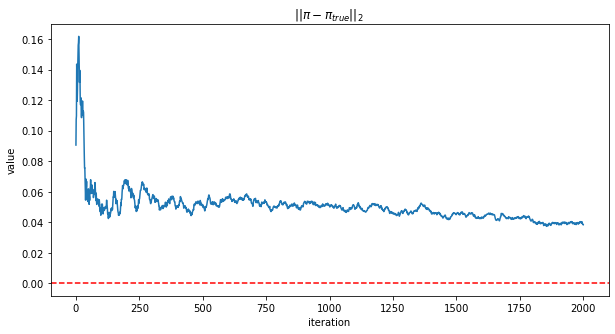

In [17]:
pi_curve = [np.linalg.norm(pi[permut_real2model] - pi_24, 2) for pi in model.pi_hist] 

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(pi_curve)), pi_curve)
plt.axhline(y = 0, color = 'r', linestyle = '--')

plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||\pi - \pi_{true}||_2$ ')
plt.show()

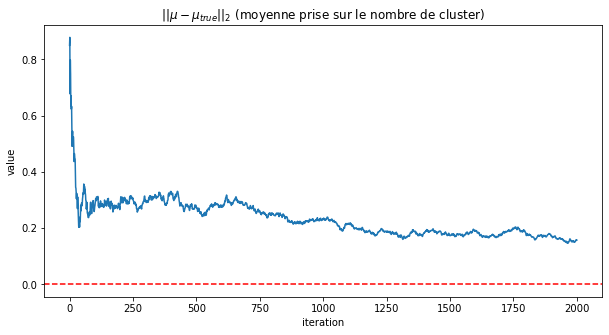

In [18]:
mu_curve = np.array([[np.linalg.norm(mu[permut_real2model][k]-mu_24[k], 2) for k in range(3)] for mu in model.mu_hist]).mean(axis=-1)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(mu_curve)), mu_curve)
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||\mu - \mu_{true}||_2$ (moyenne prise sur le nombre de cluster)')
plt.show()

In [19]:
tmp = np.swapaxes(model.D, 1, 2) @ D_24 / np.max(np.abs(np.swapaxes(model.D, 1, 2) @ D_24),
                                                         axis=-1)[..., np.newaxis]
permute = np.logical_or(tmp == 1, tmp == -1)

A_permut_hist = [(permute @ A[...,np.newaxis]).squeeze(-1) for A in model.A_hist]
nu_permut_hist = [(permute @ nu[...,np.newaxis]).squeeze(-1) for nu in model.nu_hist]
D_permut_hist = [permute @ np.abs(D) for D in model.D_hist]

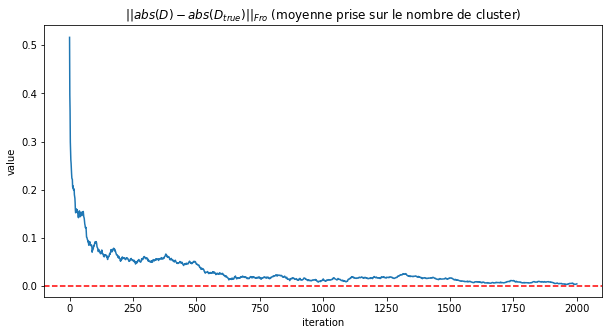

In [20]:
D_curve  = np.array([[np.linalg.norm(D[permut_real2model][k] - np.abs(D_24[k])) for k in range(3)] for D in D_permut_hist]).mean(axis=1)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(D_curve)), D_curve)
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||abs(D) - abs(D_{true})||_{Fro}$ (moyenne prise sur le nombre de cluster)')
plt.show()

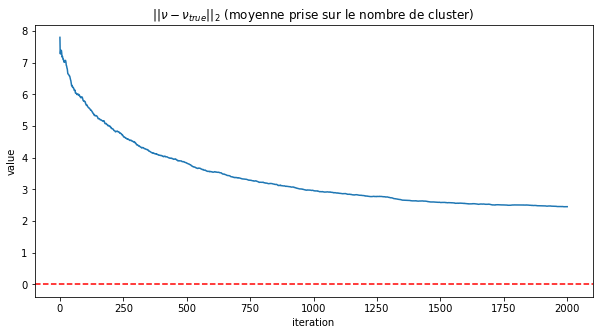

In [21]:
nu_curve = np.array([[np.linalg.norm(nu[permut_real2model][k]-nu_24[k], 2) for k in range(3)] for nu in nu_permut_hist]).mean(axis=-1)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(nu_curve)), nu_curve)
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||\nu - \nu_{true}||_2$ (moyenne prise sur le nombre de cluster)')
plt.show()

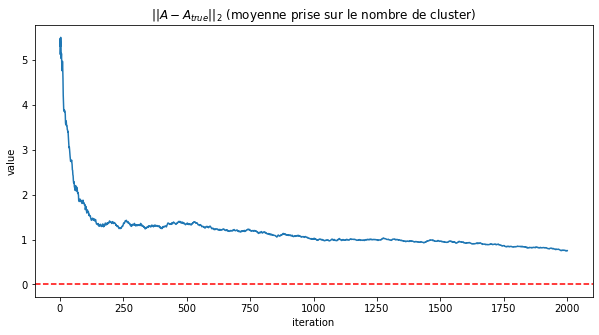

In [22]:
A_curve = np.array([[np.linalg.norm(A[permut_real2model][k]-A_24[k], 2) for k in range(3)] for A in A_permut_hist]).mean(axis=-1)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(A_curve[A_curve < 20])), A_curve[A_curve < 20])
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||A - A_{true}||_2$ (moyenne prise sur le nombre de cluster)')
plt.show()

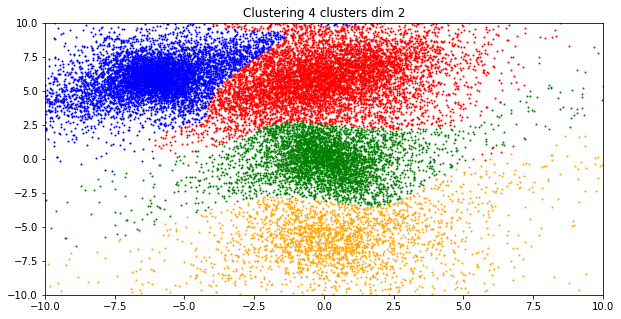

In [23]:
cluster_lab = model.predict(gen_mix_24[:25000])

cdict = {0: 'red', 1: 'blue', 2: 'green', 3: 'orange'}

fig = plt.figure(figsize=(10, 5))

for g in np.unique(cluster_lab):
    ix = np.where(cluster_lab == g)
    plt.scatter(gen_mix_24[:,0][ix], gen_mix_24[:,1][ix], c = cdict[int(g)], label = int(g), s = 1)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.title('Clustering 4 clusters dim 2')
plt.show()

### 3 clusters 3 dims


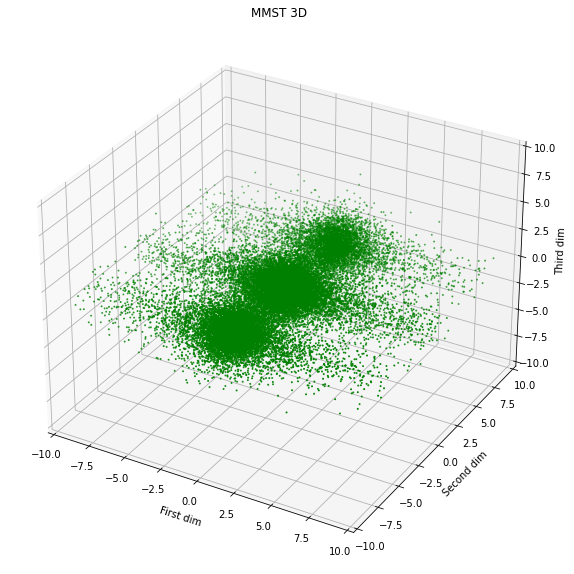

In [24]:
#3D mixtures
pi_33 = np.array([.3, .5, .2], dtype=np.float64)
mu_33 = np.array([[0, -6, 0], [0, 0, 0], [0, 6, 0]], dtype=np.float64)
angle = np.pi / 6
matRot_33 = [[1, 0, 0], [0, np.cos(angle), -np.sin(angle)], [0, np.sin(angle), np.cos(angle)]]
D_33 = np.array([matRot_33, matRot_33, matRot_33], dtype=np.float64)
A_33 = np.ones((3, 3), dtype=np.float64)
nu_33 = np.array([[1, 10, 30], [1, 10, 30], [1, 10, 30]], dtype=np.float64)

gen_mix_33 = MMST(pi_33, mu_33, A_33, D_33, nu_33).sample(1000000)
gen_mix_33 = np.array(sorted(gen_mix_33, key=lambda e: abs(e.max()) < 10 and abs(e.min()) < 10)[::-1], dtype=np.float64)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(projection='3d')

ax.scatter(gen_mix_33[:30000, 0], gen_mix_33[:30000, 1], gen_mix_33[:30000, 2], s=1, c='green')
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-10, 10)

ax.set_title("MMST 3D")

ax.set_xlabel("First dim")
ax.set_ylabel("Second dim")
ax.set_zlabel("Third dim")

plt.show()

In [25]:
model = KMeans(3, max_iter=3000, tol=1e-5)
gen_mix_init = gen_mix_33[:500]
model.fit(gen_mix_init)

pi_pred = np.array([(model.labels_ == k).sum() / len(model.labels_) for k in range(3)], dtype=np.float64)
mu_pred = np.array([gen_mix_init[model.labels_ == k].mean(0) for k in range(3)], dtype=np.float64)
D_pred = np.array([np.eye(3), np.eye(3), np.eye(3)], dtype=np.float64)
A_pred = np.ones(A_33.shape, dtype=np.float64)
nu_pred = 30 * np.ones(nu_33.shape, dtype=np.float64)

# Shuffle the data
shuffle(gen_mix_33)

# Learning rates
gam = (1-10e-10)*np.array([k for k in range(1, len(gen_mix_33) + 1)]) ** (-6/10)

# Training
model = GenStudentMixtures(pi_pred, mu_pred, A_pred, D_pred, nu_pred, max_iterations=2000)
model.fit(gen_mix_33, gam, 100)

 20%|███████▊                               | 2000/9999 [12:36<50:26,  2.64it/s]


In [26]:
print(pi_33, model.pi)

[0.3 0.5 0.2] [0.20113688 0.49328766 0.30557546]


In [27]:
permut_real2model = [2, 1, 0]

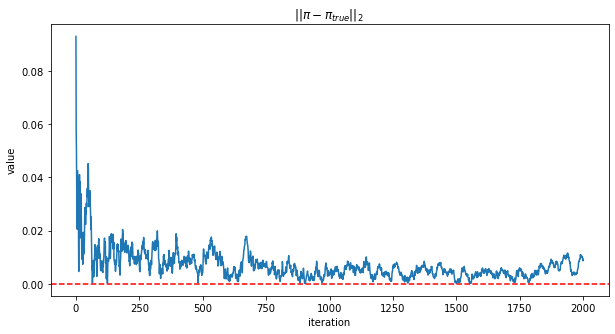

In [28]:
pi_curve = [np.linalg.norm(pi[permut_real2model] - pi_33, 2) for pi in model.pi_hist] 

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(pi_curve)), pi_curve)
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||\pi - \pi_{true}||_2$ ')
plt.show()

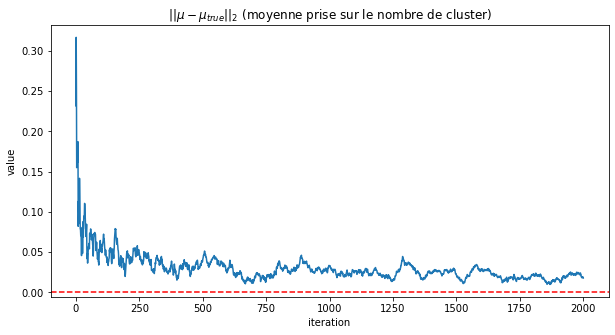

In [29]:
mu_curve = np.array([[np.linalg.norm(mu[permut_real2model][k]-mu_33[k], 2) for k in range(3)] for mu in model.mu_hist]).mean(axis=-1)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(mu_curve)), mu_curve)
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||\mu - \mu_{true}||_2$ (moyenne prise sur le nombre de cluster)')
plt.show()

In [30]:
tmp = np.swapaxes(model.D, 1, 2) @ D_33 / np.max(np.abs(np.swapaxes(model.D, 1, 2) @ D_33),
                                                         axis=-1)[..., np.newaxis]
permute = np.logical_or(tmp == 1, tmp == -1)

A_permut_hist = [(permute @ A[...,np.newaxis]).squeeze(-1) for A in model.A_hist]
nu_permut_hist = [(permute @ nu[...,np.newaxis]).squeeze(-1) for nu in model.nu_hist]
D_permut_hist = [permute @ np.abs(D) for D in model.D_hist]

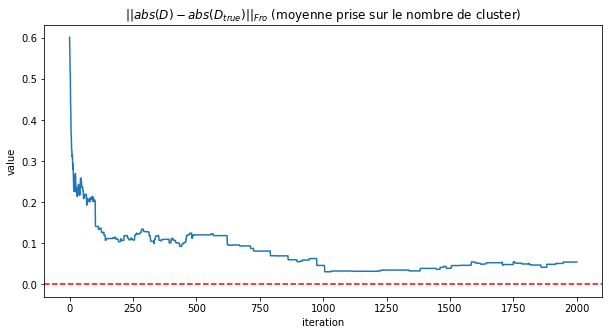

In [31]:
D_curve  = np.array([[np.linalg.norm(D[permut_real2model][k] - np.abs(D_33[k])) for k in range(3)] for D in D_permut_hist]).mean(axis=1)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(D_curve)), D_curve)
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||abs(D) - abs(D_{true})||_{Fro}$ (moyenne prise sur le nombre de cluster)')
plt.show()

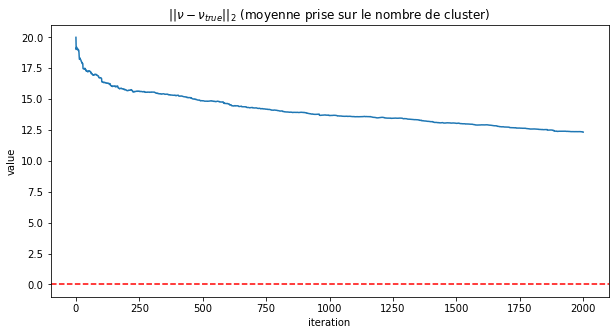

In [32]:
nu_curve = np.array([[np.linalg.norm(nu[permut_real2model][k]-nu_33[k], 2) for k in range(3)] for nu in nu_permut_hist]).mean(axis=-1)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(nu_curve)), nu_curve)
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||\nu - \nu_{true}||_2$ (moyenne prise sur le nombre de cluster)')
plt.show()

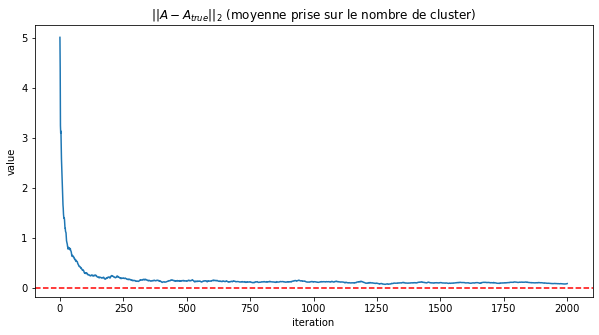

In [33]:
A_curve = np.array([[np.linalg.norm(A[permut_real2model][k]-A_33[k], 2) for k in range(3)] for A in A_permut_hist]).mean(axis=-1)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(A_curve[A_curve < 20])), A_curve[A_curve < 20])
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||A - A_{true}||_2$ (moyenne prise sur le nombre de cluster)')
plt.show()

KeyError: 3

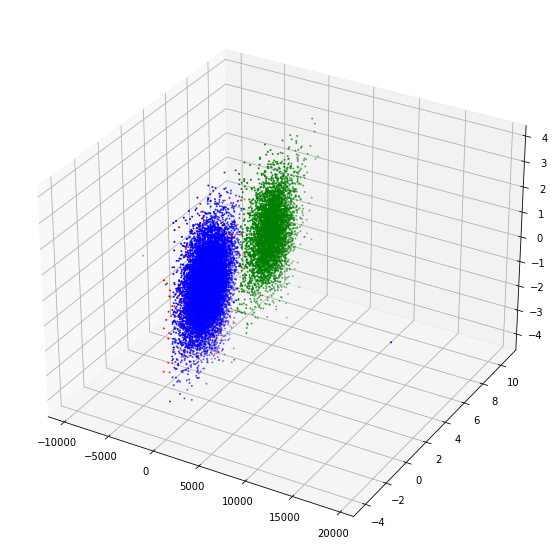

In [47]:
cluster_lab = model.predict(gen_mix_33[:25000])

cdict = {0: 'red', 1: 'blue', 2: 'green'}

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(projection='3d')
for g in np.unique(cluster_lab):
    ix = np.where(cluster_lab == g)
    ax.scatter(gen_mix_33[:,0][ix], gen_mix_33[:,1][ix], gen_mix_33[:,2][ix], c = cdict[int(g)], label = int(g), s = 1)
ax.legend()
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-10, 10)
ax.set_title('Clustering 3 clusters dim 3')

plt.show()

### 4 clusters 3 dims

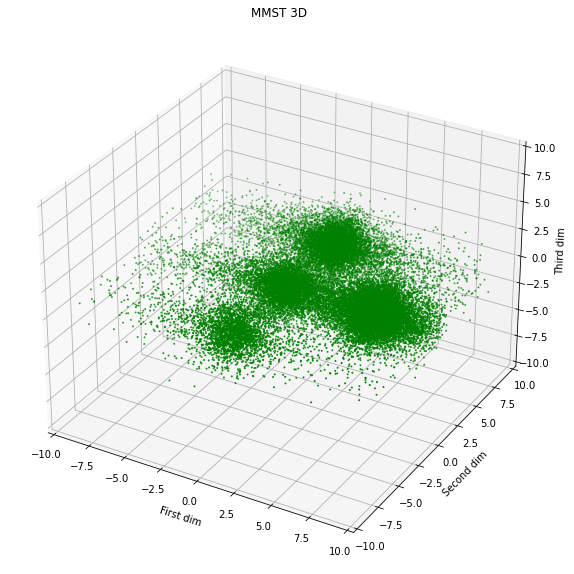

In [35]:
#3D mixtures
pi_34 = np.array([.1, .2, .3, .4], dtype=np.float64)
mu_34 = np.array([[0, -6, 0], [0, 0, 0], [0, 6, 0], [6, 0, 0]], dtype=np.float64)
angle = np.pi / 6
matRot_34 = [[1, 0, 0], [0, np.cos(angle), -np.sin(angle)], [0, np.sin(angle), np.cos(angle)]]
D_34 = np.array([matRot_34, matRot_34, matRot_34, matRot_34], dtype=np.float64)
A_34 = np.ones((4, 3), dtype=np.float64)
nu_34 = np.array([[1, 10, 30], [1, 10, 30], [1, 10, 30], [1, 10, 30]], dtype=np.float64)

gen_mix_34 = MMST(pi_34, mu_34, A_34, D_34, nu_34).sample(1000000)
gen_mix_34 = np.array(sorted(gen_mix_34, key=lambda e: abs(e.max()) < 10 and abs(e.min()) < 10)[::-1], dtype=np.float64)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(projection='3d')

ax.scatter(gen_mix_34[:30000, 0], gen_mix_34[:30000, 1], gen_mix_34[:30000, 2], s=1, c='green')
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-10, 10)

ax.set_title("MMST 3D")

ax.set_xlabel("First dim")
ax.set_ylabel("Second dim")
ax.set_zlabel("Third dim")

plt.show()

In [36]:
model = KMeans(4, max_iter=3000, tol=1e-5)
gen_mix_init = gen_mix_34[:500]
model.fit(gen_mix_init)

pi_pred = np.array([(model.labels_ == k).sum() / len(model.labels_) for k in range(4)], dtype=np.float64)
mu_pred = np.array([gen_mix_init[model.labels_ == k].mean(0) for k in range(4)], dtype=np.float64)
D_pred = np.array([np.eye(3), np.eye(3), np.eye(3), np.eye(3)], dtype=np.float64)
A_pred = np.ones(A_34.shape, dtype=np.float64)
nu_pred = 30 * np.ones(nu_34.shape, dtype=np.float64)

# Shuffle the data
shuffle(gen_mix_34)

# Learning rates
gam = (1-10e-10)*np.array([k for k in range(1, len(gen_mix_34) + 1)]) ** (-6/10)

# Training
model = GenStudentMixtures(pi_pred, mu_pred, A_pred, D_pred, nu_pred, max_iterations=2000)
model.fit(gen_mix_34, gam, 100)

 20%|███████▊                               | 2000/9999 [14:36<58:24,  2.28it/s]


In [37]:
print(pi_34, model.pi)

[0.1 0.2 0.3 0.4] [0.3335245  0.26291531 0.29747939 0.1060808 ]


In [38]:
permut_real2model = [3, 1, 2, 0]

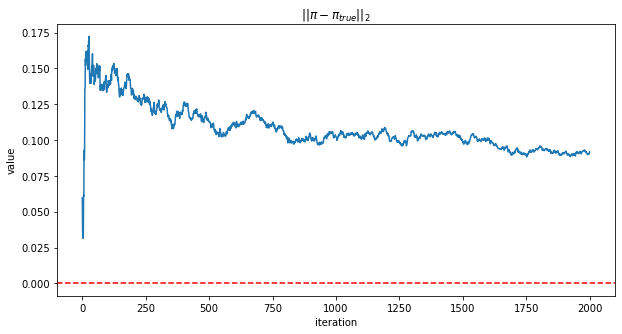

In [39]:
pi_curve = [np.linalg.norm(pi[permut_real2model] - pi_34, 2) for pi in model.pi_hist] 

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(pi_curve)), pi_curve)
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||\pi - \pi_{true}||_2$ ')
plt.show()

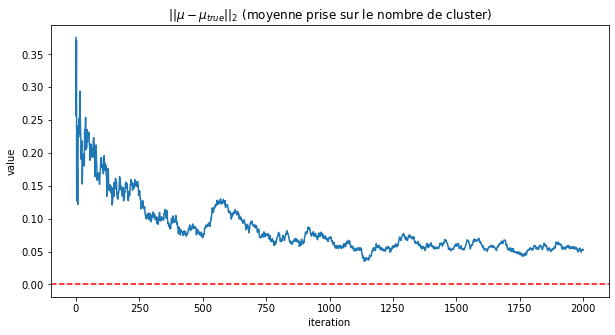

In [40]:
mu_curve = np.array([[np.linalg.norm(mu[permut_real2model][k]-mu_34[k], 2) for k in range(3)] for mu in model.mu_hist]).mean(axis=-1)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(mu_curve)), mu_curve)
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||\mu - \mu_{true}||_2$ (moyenne prise sur le nombre de cluster)')
plt.show()

In [41]:
tmp = np.swapaxes(model.D, 1, 2) @ D_34 / np.max(np.abs(np.swapaxes(model.D, 1, 2) @ D_34),
                                                         axis=-1)[..., np.newaxis]
permute = np.logical_or(tmp == 1, tmp == -1)

A_permut_hist = [(permute @ A[...,np.newaxis]).squeeze(-1) for A in model.A_hist]
nu_permut_hist = [(permute @ nu[...,np.newaxis]).squeeze(-1) for nu in model.nu_hist]
D_permut_hist = [permute @ np.abs(D) for D in model.D_hist]

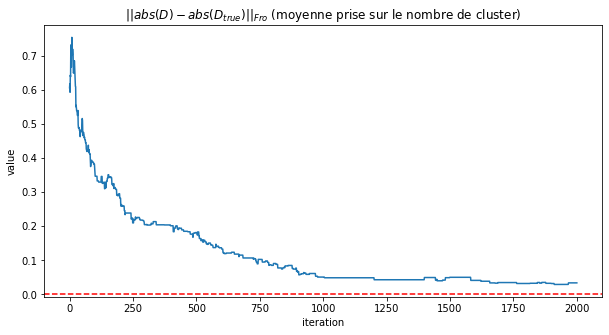

In [42]:
D_curve  = np.array([[np.linalg.norm(D[permut_real2model][k] - np.abs(D_34[k])) for k in range(3)] for D in D_permut_hist]).mean(axis=1)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(D_curve)), D_curve)
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||abs(D) - abs(D_{true})||_{Fro}$ (moyenne prise sur le nombre de cluster)')
plt.show()

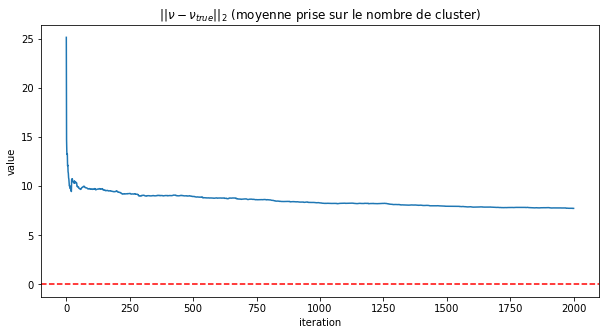

In [43]:
nu_curve = np.array([[np.linalg.norm(nu[permut_real2model][k]-nu_34[k], 2) for k in range(3)] for nu in nu_permut_hist]).mean(axis=-1)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(nu_curve)), nu_curve)
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||\nu - \nu_{true}||_2$ (moyenne prise sur le nombre de cluster)')
plt.show()

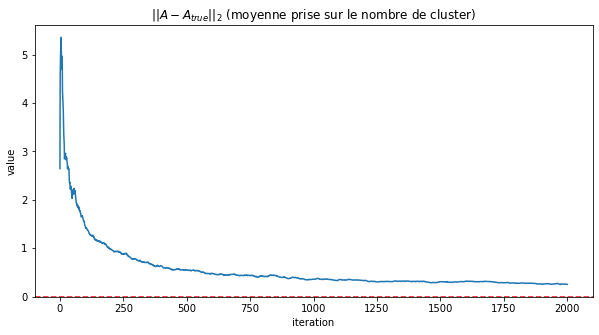

In [44]:
A_curve = np.array([[np.linalg.norm(A[permut_real2model][k]-A_34[k], 2) for k in range(3)] for A in A_permut_hist]).mean(axis=-1)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(A_curve[A_curve < 20])), A_curve[A_curve < 20])
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||A - A_{true}||_2$ (moyenne prise sur le nombre de cluster)')
plt.show()

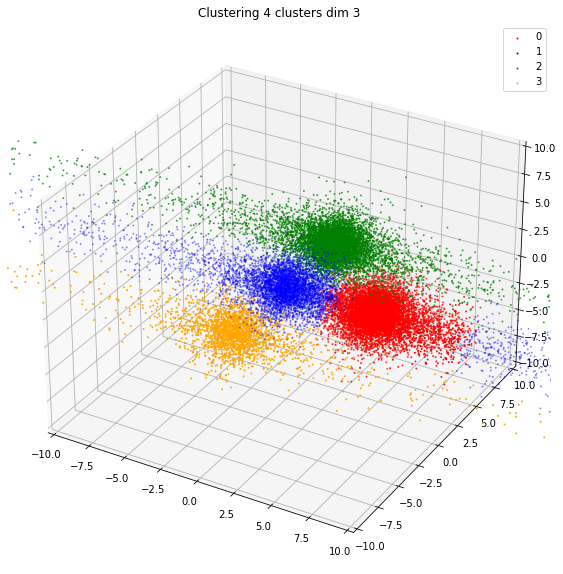

In [46]:
cluster_lab = model.predict(gen_mix_34[:25000])

cdict = {0: 'red', 1: 'blue', 2: 'green', 3:'orange'}

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(projection='3d')

for g in np.unique(cluster_lab):
    ix = np.where(cluster_lab == g)
    ax.scatter(gen_mix_34[:,0][ix], gen_mix_34[:,1][ix], gen_mix_34[:,2][ix], c = cdict[int(g)], label = int(g), s = 1)
ax.legend()
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-10, 10)
ax.set_title('Clustering 4 clusters dim 3')

plt.show()